In [0]:
%tensorflow_version 1.x

In [0]:
import tensorflow as tf
from tensorflow.python import keras
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, Input, BatchNormalization, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt


from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler

In [34]:
import numpy 

#fix random seed for reproducibility
seed= 1234
numpy.random.seed(seed)

# load minit data
(X_train, y_train),(X_test, y_test) = mnist.load_data()

#printng shape of mnist train and test data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

'''
CNN accepts a specific format when using tensorflow e.g.(batch, height, width, channels)
As all the images are in grayscale, the number of channels is 1
'''
# reshape the data to four dimensions, due to the input of model
# reshape to be [samples/batch][width][height][pixels/channels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

'''
rescaled the image data below so that each pixel lies in the interval [0, 1] instead of [0, 255].
'''
# Normalization
X_train /= 255.0
X_test /= 255.0
#print(X_train[0])

'''
encode the labels i.e. Y_train and Y_test. 
In one-hot encoding an integer is converted to an array which contains only 
one ‘1’ and the rest elements are ‘0’.
'''
# one-hot
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print('Shape of y-train(One-hot)', y_train.shape)
print('Shape of y-test(One-hot)',y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
Shape of y-train(One-hot) (60000, 10)
Shape of y-test(One-hot) (10000, 10)


In [0]:
# ResNet-20
depth = 20

# Number of Classes
num_classes = 10

def resnet_layer(inputs, num_filters=14, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    """
    2D convolution batch-normalization-activation stack builder
    Arguments
        inputs: input tensor from input image or prev layer
        num_filters: conv2D number of filters
        kernel_size: conv2D square kernel dimensions
        strides: conv2D square stride dimensions
        activation: activation name
        batch_normalization: to include batch_normalization or not
        conv_first: order of convolution
    Returns
        x: tensor as input to next layer
    """

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    x = inputs

    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)

    return x

def resnet_model(input_shape, depth, num_classes):
    """
    resnet model builder
    Arguments
        input_shape: shape of the input image tensor
        depth: number of core convolutional layers
        num_classes: number of classes
    Returns
        model: Keras model instance
    """

    num_filters = 14
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # for first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None)
            if stack > 0 and res_block == 0:  # for first layer but not first stack
                # linear projection residual shortcut connection to match changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
        
        # add classifier on top
    x = AveragePooling2D(pool_size=(2,2))(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [36]:
# input image dimensions
input_shape = (28,28,1)

model = resnet_model(input_shape=input_shape, depth=depth, num_classes=10)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 14)   140         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 28, 28, 14)   56          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 28, 28, 14)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [0]:
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy']) #

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, shuffle=True, ) #callbacks=[learn_rate_scheduler]

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 19s 319us/sample - loss: 0.2189 - acc: 0.9653 - val_loss: 0.1478 - val_acc: 0.9823
Epoch 2/10
60000/60000 [==============================] - 18s 295us/sample - loss: 0.1278 - acc: 0.9884 - val_loss: 0.1277 - val_acc: 0.9876
Epoch 3/10
60000/60000 [==============================] - 18s 294us/sample - loss: 0.1101 - acc: 0.9929 - val_loss: 0.1271 - val_acc: 0.9856
Epoch 4/10
60000/60000 [==============================] - 18s 297us/sample - loss: 0.0997 - acc: 0.9939 - val_loss: 0.1177 - val_acc: 0.9867
Epoch 5/10
60000/60000 [==============================] - 18s 295us/sample - loss: 0.0884 - acc: 0.9963 - val_loss: 0.1033 - val_acc: 0.9911
Epoch 6/10
60000/60000 [==============================] - 18s 298us/sample - loss: 0.0809 - acc: 0.9970 - val_loss: 0.0941 - val_acc: 0.9926
Epoch 7/10
60000/60000 [==============================] - 18s 301us/sample - loss: 0.0758 - acc: 0.9971 

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)

In [40]:
print("Accuracy on test set: ",score[1])

Accuracy on test set:  0.9925


In [41]:
model.metrics_names


['loss', 'acc']

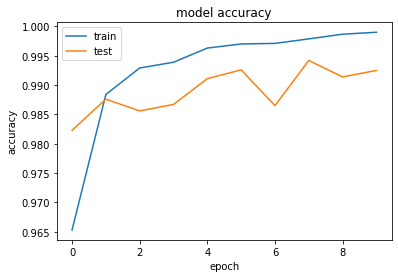

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

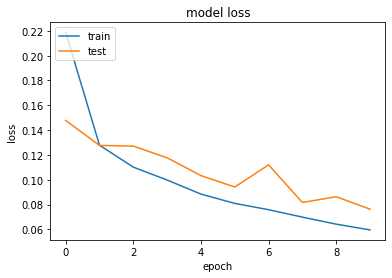

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()